## Functions and Modules

In [2]:
using CSV
using Tables
using LinearAlgebra
using Plots
using NearestNeighbors
using Optim


In [3]:

function ReadData_(sw,pot)
    Λ = pot/4000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    problemName = "CM-O2-PL"
    for s in sw
        problemName = problemName*"_$s"
    end
    problemName = problemName*"_ϕ40000.0"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    X_z = _X[:,3]
    x_x = _X[:,7]
    x_y = _X[:,8]
    x_z = _X[:,9]
    x = []
    i = 1
    for X_z_i in X_z
        if X_z_i == 0.0004
            push!(x,x_z[i])
        end
        i +=1
    end
    return x
end

function ReadData_i(sw,pot)
    Λ = pot/4000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    problemName = "CM-O2-PL"
    for s in sw
        problemName = problemName*"_$s"
    end
    problemName = problemName*"_ϕ40000.0"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    X_z = _X[:,3]
    x_x = _X[:,7]
    x_y = _X[:,8]
    x_z = _X[:,9]
    x = []
    i = 1
    for X_z_i in X_z
        if X_z_i == 0.0004
            push!(x,x_x[i])
            push!(x,x_y[i])
            push!(x,x_z[i])
        end
        i +=1
    end
    return x
end

function ReadData_j(sw,pot)
    Λ = pot/4000
    θ_list = [0, pi/4, pi/2, 3*pi/4, pi, 5*pi/4, 3*pi/2, 7*pi/4, pi]
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    problemName = "CM-O2-PL"
    for s in sw
        problemName = problemName*"_$s"
    end
    problemName = problemName*"_ϕ40000.0"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    X_x = _X[:,1]
    X_y = _X[:,2]
    X_z = _X[:,3]
    x_x = _X[:,7]
    x_y = _X[:,8]
    x_z = _X[:,9]
    x = []
    i = 1
    for X_z_i in X_z
        θ_bool = false
        if X_x[i] < 1e-12
            θ_bool = true
        elseif X_y[i] < 1e-12
            θ_bool = true
        elseif X_x[i]==X_y[i]
            θ_bool = true
        elseif X_x[i]==-X_y[i]
            θ_bool = true
        end
        if X_z_i == 0.0004 && θ_bool
            # push!(x,x_x[i])
            # push!(x,x_y[i])
            push!(x,x_z[i])
        end
        i +=1
    end
    return x
end


ReadData_j (generic function with 1 method)

In [4]:

function kPOD(Κ,X,k)
    m, n = size(X)
    # X̄ = [1. for i in 1:n]
    # mean!(X̄',X)
    # for i in 1:n
    #     X[:,i] = X[:,i].-X̄[i]
    # end
    G = [Κ(X[:,i],X[:,j]) for i in 1:n, j in 1:n]
    # display(G)
    II = ones(n,n)
    Ḡ = G - (1/n)*G*II - (1/n)*II*G + (1/n^2)*II*G*II 
    # display(Ḡ)
    f(λ)=-abs(λ)
    Λ_ = eigen(Ḡ,sortby=f)
    Λ = Λ_.values
    U = Λ_.vectors
    Σ = diagm(real.(sqrt.(complex(Λ))))
    Σ_ = Σ[:,[1:k...]]
    U_ = U*pinv(Σ_')
    # U_ = U[:,1:k]
    return Λ, U, U_, Ḡ, G
end

function plot_eigen(Λ)
    Λ = real.(Λ)
    Λ_t = sum(Λ)
    Λ = (1/Λ_t)*Λ
    Λ_s = round.(100*Λ[[i for i in 1:10]])
    p = plot(real.(Λ_s),type="bar",xlabel="λ",ylabel="%", legend=false, hover=real.(Λ_s))
    display(p)
end

function isomap1(neighbors,Z_)
    n = length(eachcol(Z_))
    D_G = [[] for i in 1:n]
    count = []
    count2 = []
    Threads.@threads for i in 1:n
        d_G, prev_ = Dijkstra(Z_,i,neighbors)
        D_G[i] = d_G
        push!(count,i)
        ma = maximum(count)
        push!(count2,ma)
        mi = minimum(count2)
        per = round(100*((ma-mi)/(n-mi)))
        print("\r$ma - $mi - %$per")
    end
    print("\n")
    D_G = reduce(hcat,D_G)
    D_G_sym = 0.5*(D_G+D_G')
    D_G_sq = D_G_sym.^2
    C = I - (1/n)*ones(n,n)
    B = -0.5*C*D_G_sq*C
    f(λ) = -real(λ)
    _iso = eigen(B, sortby=f)
    Λ_iso = real.(_iso.values)
    U_iso = real.(_iso.vectors)
    Λ_iso_m = diagm(sqrt.(Λ_iso[[1,2]]))
    U_iso_m = U_iso[:,[1,2]]
    X_iso = U_iso_m*Λ_iso_m
    return X_iso', D_G_sym
end

function Dijkstra(data,i,nieghbors)
    m, n = size(data)
    dist = [Inf64 for i in 1:n]
    prev = [0 for i in 1:n]
    nodes = data
    kdtree = KDTree(nodes; leafsize = 10)
    dist[i] = 0
    visited = []
    dist_ = copy(dist)
    while length(visited)<n
        # println(length(visited))
        u = argmin(dist_)
        append!(visited,u)
        distu = dist[u]
        idxs, dists = knn(kdtree, data[:,u], nieghbors, true,
        x -> maximum(isequal.(x,visited)))
        for i in 1:lastindex(idxs)
            alt = distu + dists[i]
            if alt<dist[idxs[i]]
                dist[idxs[i]]=alt
                prev[idxs[i]]=u
            end
        end
        dist_ = copy(dist)
        dist_[visited].=Inf64
    end
    return dist, prev
end

function VectorSearch(Z_,conf,list)
    n = length(list)
    z = Z_[:,list]
    v = [z[:,i]-Z_[:,1] for i in 1:n]
    z = Z_[:,1]
    for i in 1:4
        c = conf[i]
        if c == 0
            z = z
        elseif c == 1
            z = z + v[i+1]
        elseif c == 2
            z = z + v[i+5]
        end
    end
    return z
end

function Objective(β)
    println("β value $β")
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
    Z_ = real.(U_'*Ḡ)
    Y_, D_G_sym = isomap1(neighbors,Z_)
    Y_gen = []
    for conf in conf_list
        push!(Y_gen, VectorSearch(Y_, conf, VS_list))
    end
    Y_gen = reduce(hcat, Y_gen)
    println(norm(Y_gen-Y_)/norm(Y_))
    return norm(Y_gen-Y_)/norm(Y_)
end

Objective (generic function with 1 method)

In [43]:
function plot_CM(conf,pot)
    sw = conf
    Λ = pot/4000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    problemName = "CM-O2-PL"
    for s in sw
        problemName = problemName*"_$s"
    end
    problemName = problemName*"_ϕ40000.0"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    X_z = _X[:,3]
    x_x = _X[:,7]
    x_y = _X[:,8]
    x_z = _X[:,9]
    x = [[], [], []]
    i = 1
    for X_z_i in X_z
        if X_z_i == 0.0004
            push!(x[1], x_x[i])
            push!(x[2], x_y[i])
            push!(x[3], x_z[i])
        end
        i +=1
    end
    display(
        scatter(
            x...,xlabel = "X", ylabel = "Y", zlabel = "Z",
            xlims = (-0.05,0.05), ylims = (-0.05,0.05), 
            zlims = (-0.05,0.05),
            label = "$conf"
            )
            )

end

plot_CM (generic function with 1 method)

# Main Execution

## Data collection

In [6]:
cd("c:\\Users\\mjbarillas\\Documents\\GitHub\\Mimosa")

In [7]:
conf_list = []
for i in 0:2, j in 0:2, k in 0:2, l in 0:2
  push!(conf_list,[i,j,k,l,i,j,k,l,i,j,k,l,i,j,k,l])
end
pot = 3200
X = []
conf_NF_list = []
for conf in conf_list
  println(conf)
    # try
    #     push!(X,ReadData_i(conf,pot))
    # catch
    #     push!(conf_NF_list,conf)
    # end
    push!(X,ReadData_(conf,pot))
end
X = reduce(hcat,X)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
[0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2]
[0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0]
[0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1]
[0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2]
[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2]
[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
[0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2]
[0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0]
[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1]
[0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 2, 2]
[0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0]
[0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1]
[0, 2, 0, 2, 0, 2, 0

1920×81 Matrix{Any}:
 0.0004   0.00039988   0.000396405  …   0.000393515  0.000393972
 0.0004   0.000337913  0.000458372      0.000363579  0.000395952
 0.0004   0.00041936   0.000376926      0.000509095  0.000395952
 0.0004   0.000283449  0.000512836      0.000280294  0.000396967
 0.0004   0.000337913  0.000458372      0.000363579  0.000395952
 0.0004   0.000160903  0.000635383  …   0.000261807  0.000402122
 0.0004   0.000283449  0.000512836      0.000280294  0.000396967
 0.0004   0.000112589  0.000683697      0.000114722  0.000401179
 0.0004   0.00041936   0.000376926      0.000509095  0.000395952
 0.0004   0.000283449  0.000512836      0.000280294  0.000396967
 0.0004   0.000468652  0.000327634  …   0.000867742  0.000402122
 0.0004   0.000292079  0.000504207      0.000453841  0.000401179
 0.0004   0.000283449  0.000512836      0.000280294  0.000396967
 ⋮                                  ⋱                ⋮
 0.0004  -0.00413319   0.00492948      -0.000792083  0.00177576
 0.0004  -0.003

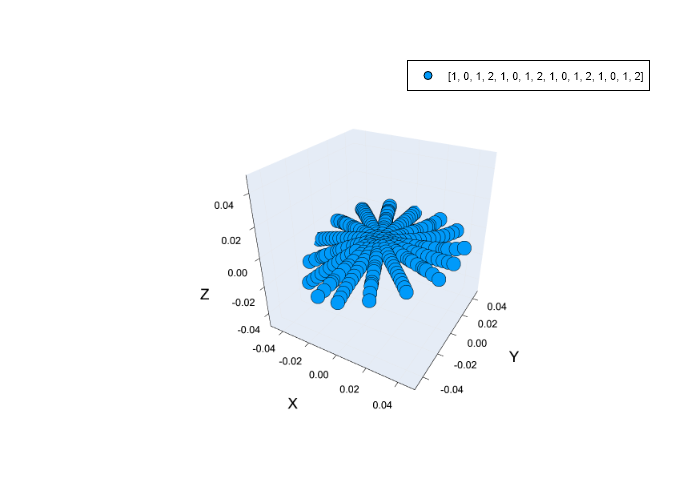

In [63]:
plotlyjs()
plot_CM(conf_list[33],pot)

## kPCA

In [45]:


k = 3


3

In [46]:
β = 1.39


1.39

In [ ]:
β = β_min.minimizer

In [47]:
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
Z_ = real.(U_'*Ḡ)


3×81 Matrix{Float64}:
  2.91623e-5  -0.106586   0.106593  …  -0.106258  -0.25225   -6.99794e-5
 -0.00123416   0.103623  -0.105961      0.103752   0.2512    -0.000607387
 -0.00295695   0.135315  -0.141555     -0.310701  -0.224979  -0.0811044

In [27]:
plotlyjs()


Plots.PlotlyJSBackend()

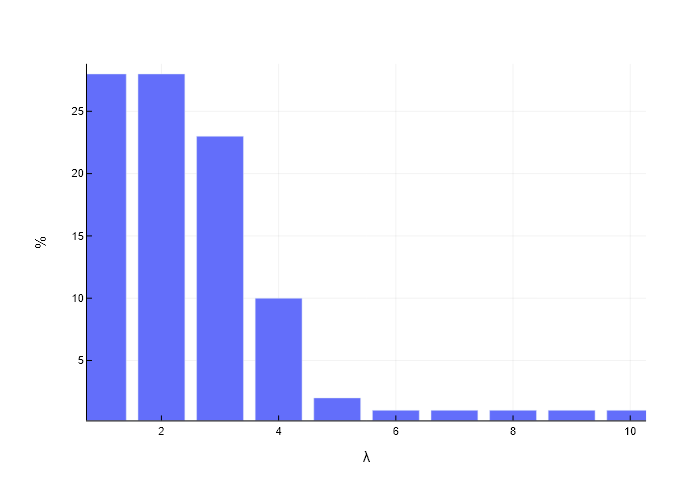

In [48]:
plot_eigen(Λ)


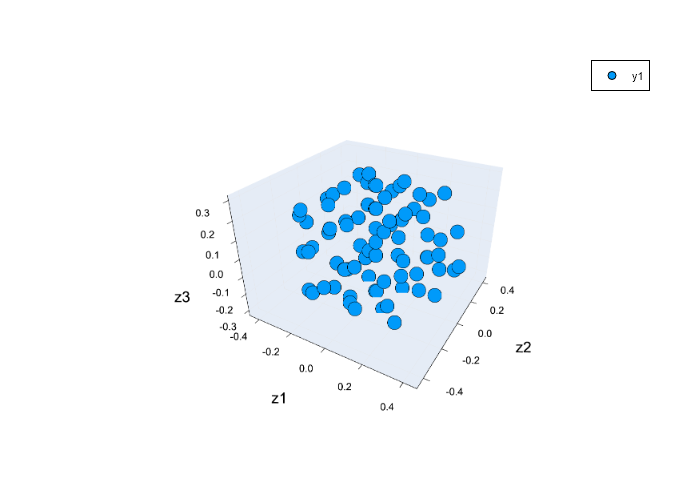

In [49]:
scatter(eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3",hover = [i for i in 1:lastindex(eachcol(Z_))])


## ISOMAP

In [50]:
neighbors = 20
t_o = time()
Y_, D_G_sym = isomap1(neighbors,Z_)
t_i = time() - t_o


81 - 1 - %100.0


2.5880000591278076

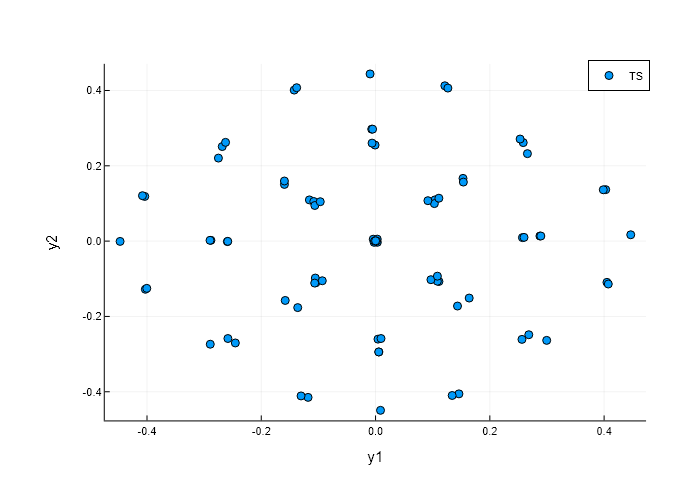

In [51]:
scatter(eachrow(Y_)..., hover = [i for i in 1:lastindex(eachcol(Z_))],
xlabel="y1",ylabel="y2", label = "TS")

In [ ]:
pwd()

## Vector search

In [52]:
Ref_conf = [0 for i in 1:16]
Ref_conf_list = []
# println(Ref_conf)
push!(Ref_conf_list,Ref_conf)
for i in 1:4
    Ref_conf_0 = copy(Ref_conf)
    # println(Ref_conf)
    Ref_conf_0[i] = 1; Ref_conf_0[i+4] = 1; Ref_conf_0[i+8] = 1; Ref_conf_0[i+12] = 1;
    push!(Ref_conf_list,Ref_conf_0)
end
for i in 1:4
    Ref_conf_0 = copy(Ref_conf)
    Ref_conf_0[i] = 2; Ref_conf_0[i+4] = 2; Ref_conf_0[i+8] = 2; Ref_conf_0[i+12] = 2;
    push!(Ref_conf_list,Ref_conf_0)
end

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
Ref_conf_list

In [54]:
VS_list = []
for Ref_conf in Ref_conf_list
    i = 1
    for conf in conf_list
        if conf == Ref_conf
            push!(VS_list,i)
        end
        i += 1
    end
end

## TS generation

In [55]:
Y_gen = []
for conf in conf_list
    push!(Y_gen,VectorSearch(Y_,conf,VS_list))
end
Y_gen = reduce(hcat,Y_gen)

2×81 Matrix{Float64}:
 -3.56941e-5   0.110943  -0.115789  …   0.114583   0.225561  -0.00117064
  0.00177262  -0.107098   0.10947      -0.106645  -0.215516   0.00105223

In [56]:
norm(Y_gen-Y_)/norm(Y_)

0.18792310435666995

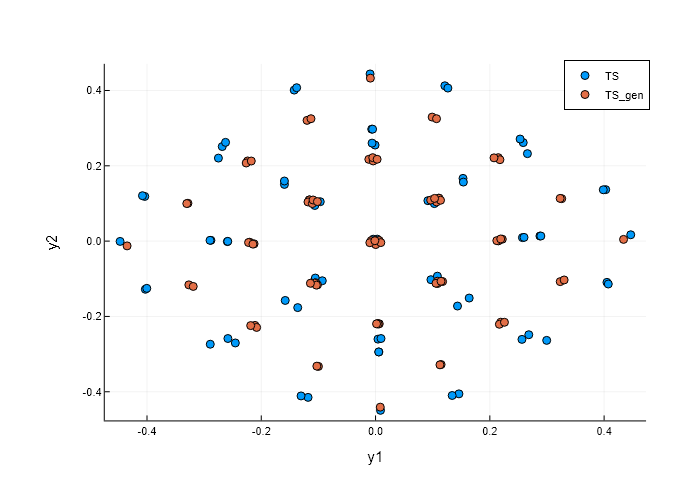

In [57]:
scatter!(eachrow(Y_gen)..., hover = [i for i in 1:lastindex(eachcol(Z_))],
xlabel="y1",ylabel="y2", label = "TS_gen")

## optimization of the kernel parameter

In [ ]:
β_min = optimize(Objective, 0.0, 15.0, GoldenSection(),f_tol=1.0e-6,iterations=50)

## Linear transformation

In [58]:
function Objective6_(x,x_,X_)
    θ = x[1]
    α = x[2]
    rot = [cos(θ) -sin(θ);sin(θ) cos(θ)]
    scale = [α 0;0 α]
    x_ = rot*x_
    x_ = scale*x_
    return norm(X_-x_)/norm(X_)
end


Objective6_ (generic function with 1 method)

In [59]:
Objective6(x) = Objective6_(x,Y_gen,Y_)
x0 = [0.0,1.0]


2-element Vector{Float64}:
 0.0
 1.0

In [60]:
_min = optimize(Objective6, x0, NelderMead())


 * Status: success

 * Candidate solution
    Final objective value:     1.024742e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    27
    f(x) calls:    53


In [61]:
θ = _min.minimizer[1]
α = _min.minimizer[2]
rot = [cos(θ) -sin(θ);sin(θ) cos(θ)]
scale = [α 0;0 α]
Y_gen = rot*Y_gen
Y_gen = scale*Y_gen
Err_TS_2 = norm(Y_gen-Y_)/norm(Y_)

0.10247417712881307

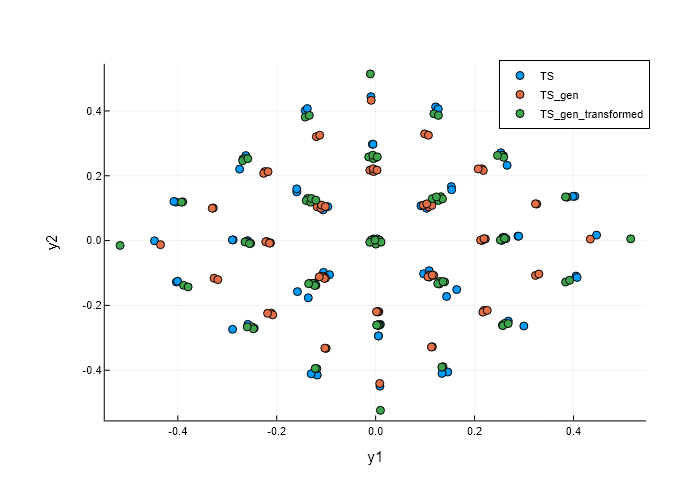

In [62]:
scatter!(eachrow(Y_gen)..., hover = [i for i in 1:lastindex(eachcol(Z_))],
xlabel="y1",ylabel="y2", label = "TS_gen_transformed")